# Машинное обучение, ФЭН ВШЭ

__Дата выдачи: 26.11.2017__
__Дедлайн: 15.12.2017 23:59__

# Практическое задание 4


### О задании

Практическое задание 4 посвящено ансамблям, bias-variance decomposition, деревьям и нейронным сетям. Обучение нейронных сетей займет какое-то время, поэтому не оставляйте эту часть на последний день!

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW4_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW4_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

34.233162684174431

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

20.165875596272031

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
#####  Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000).reshape(-1, 1)  # точки для построения графиков

__1 (0.6 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [6]:
x = np.random.exponential(size=sample_size).reshape(-1, 1)

In [7]:
noize_mc = np.random.uniform(-1, 1, sample_size).reshape(-1, 1)

In [8]:
y = f(x) + noize_mc

In [9]:
from sklearn import tree
reg = tree.DecisionTreeRegressor()
reg.fit(x, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [10]:
y_pred = reg.predict(linspace)

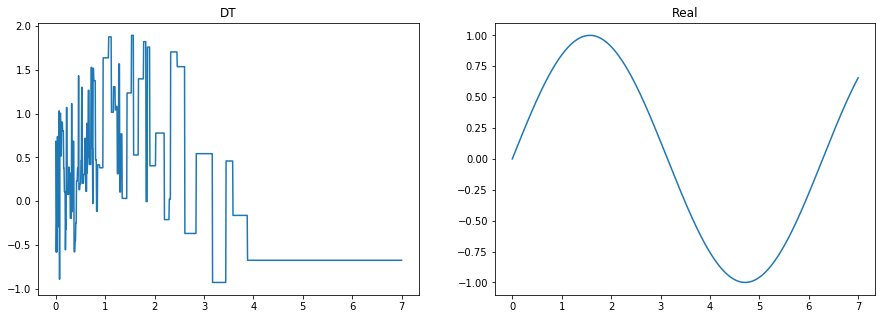

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(linspace, y_pred)
plt.title('DT')
plt.subplot(1, 2, 2)
plt.plot(linspace, f(linspace))
plt.title('Real')


__2 (0.6 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

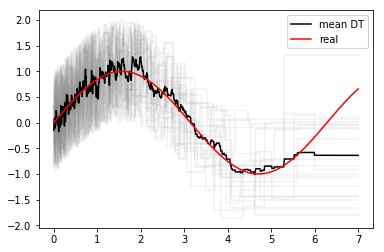

In [12]:
y_pred_mean = 0
for i in range(samples_num):
    x = np.random.exponential(size=sample_size).reshape(-1, 1)
    noize_mc = np.random.uniform(-1, 1, sample_size).reshape(-1, 1)
    y = f(x) + noize_mc

    reg = tree.DecisionTreeRegressor()
    reg.fit(x, y)
    y_pred = reg.predict(linspace)
    y_pred_mean += y_pred
    plt.plot(linspace, y_pred, color="grey", alpha=0.1)
y_pred_mean = (y_pred_mean/samples_num).reshape(-1, 1)
plt.plot(linspace, y_pred_mean, color = 'black', label='mean DT')
plt.plot(linspace, f(linspace), color = 'red', label='real')
plt.legend()

__3 (0.2 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

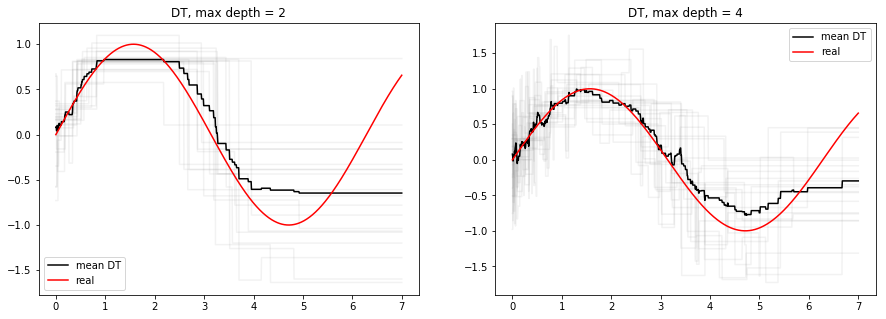

In [13]:
plt.figure(figsize=(15,5))
for m in [2, 4]:
    y_pred_mean = 0
    for i in range(samples_num):
        x = np.random.exponential(size=sample_size).reshape(-1, 1)
        noize_mc = np.random.uniform(-1, 1, sample_size).reshape(-1, 1)
        y = f(x) + noize_mc

        reg = tree.DecisionTreeRegressor(max_depth = m)
        reg.fit(x, y)
        y_pred = reg.predict(linspace)
        y_pred_mean += y_pred
        plt.subplot(1, 2, m/2)
        plt.plot(linspace, y_pred, color="grey", alpha=0.1)
    y_pred_mean = (y_pred_mean/samples_num).reshape(-1, 1)
    plt.subplot(1, 2, m/2)
    plt.plot(linspace, y_pred_mean, color = 'black', label='mean DT')
    plt.plot(linspace, f(linspace), color = 'red', label='real')
    plt.legend()
    plt.title('DT, max depth = ' + str(m))

__4 (0.6 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

-----

Смещение близко к нуля в случае без ограничения на максимальную длину, при ограничении 2 - наибольшее смещение. 
При большей глубине он обучается "до упора" - пока число объектов в листе не будет совсем небольшим. При этом возрастает разброс значений.

-----

__5 (1 балл)__
Проделайте тот же эксперимент с линейной регрессией и SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$. Какие выводы можно сделать?

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


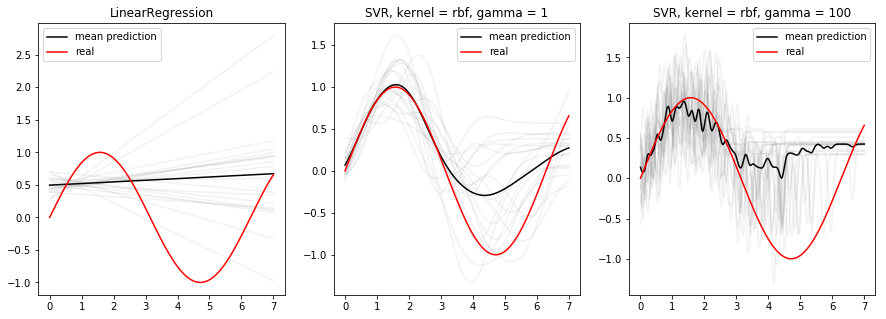

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

reg1 = LinearRegression()
reg2 = SVR(kernel = 'rbf', gamma = 1)
reg3 = SVR(kernel = 'rbf', gamma = 100)
reg_list5 = [reg1, reg2, reg3]
reg_names = ['LinearRegression', 'SVR, kernel = rbf, gamma = 1', 'SVR, kernel = rbf, gamma = 100']
plt.figure(figsize=(15,5))
for m in range(3):
    y_pred_mean = 0
    
    for i in range(samples_num):
        x = np.random.exponential(size=sample_size).reshape(-1, 1)
        noize_mc = np.random.uniform(-1, 1, sample_size).reshape(-1, 1)
        y = f(x) + noize_mc

        reg = reg_list5[m]
        reg.fit(x, y)
        y_pred = reg.predict(linspace)
        y_pred_mean += y_pred
        plt.subplot(1, 3, m+1)
        plt.plot(linspace, y_pred, color="grey", alpha=0.1)
        
    y_pred_mean = (y_pred_mean/samples_num).reshape(-1, 1)
    
    plt.subplot(1, 3, m+1)
    plt.plot(linspace, y_pred_mean, color = 'black', label='mean prediction')
    plt.plot(linspace, f(linspace), color = 'red', label='real')
    plt.legend()
    plt.title(reg_names[m])

----

В линейной регрессии получаем.... прямую линию. Результат предсказуемый :) (не знаю что тут еще сказать).

В SVR:

При $\gamma = 1$ график получается более гладким, с меньшим разбросом. При этом - достаточно точным. 

При $\gamma = 100$ ответы с большим разбросом, хотя и похоже по точности.

----

### II. Решающие деревья

__5 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassfier, считающий все признаки категориальными
* DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки.

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [16]:
mdf = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data', header = None)
tdf = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data', header = None)
cdf = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header = None)
ndf = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', header = None)

In [17]:
# С обычным cv =3 получается очень странно и меньше скор и вообще странно. 
# Можно просто перемешивать изначально (через shuffle - как в 8), можно - на каждой итерации (как здесь и реализовано). 
# Результат один  - лучше, чем просто cv=3. (особенно - в 7 задании)
cv = ShuffleSplit(n_splits= 10, test_size=0.3, random_state=42) 

мушрумс

In [18]:
my = mdf[0]
mx = mdf.drop(0, 1)

mdum = pd.get_dummies(mx)

le = LabelEncoder()
my = le.fit_transform(my)

for i in range(len(mx.columns)):
    mx[i+1] = le.fit_transform(mx[i+1])

In [19]:
# Все признаки вещественные
cross_val_score(estimator = DecisionTreeClassifier(),
                scoring = make_scorer(accuracy_score), X = mx, y = my, cv = cv).mean()

1.0

In [20]:
# Все признаки категориальные
cross_val_score(estimator = DecisionTreeClassifier(), 
                scoring = make_scorer(accuracy_score), X = mdum, y = my, cv = cv).mean()

1.0

тикракто

In [21]:
ty = tdf[9]
tx = tdf.drop(9, 1)

tdum = pd.get_dummies(tx)


le.fit(ty)
ty = le.fit_transform(ty)

for i in range(len(tx.columns)):
    tx[i] = le.fit_transform(tx[i])

In [22]:
# Все признаки вещественные
cross_val_score(estimator = DecisionTreeClassifier(), 
                scoring = make_scorer(accuracy_score), X = tx, y = ty, cv = cv).mean()

0.88124999999999998

In [23]:
# Все признаки категориальные
cross_val_score(estimator = DecisionTreeClassifier(), 
                scoring = make_scorer(accuracy_score), X = tdum, y = ty, cv = cv).mean()

0.9253472222222221

машины

In [24]:
cy = cdf[6]
cx = cdf.drop(6, 1)

cdum = pd.get_dummies(cx)

cy[cy.isin(['acc', 'unacc'])] = 0
cy[cy.isin(['good', 'vgood'])]= 1

c_correct = cx.copy()

c_correct[c_correct.isin(['low', 'small'])] = 0
c_correct[c_correct.isin(['med'])] = 1
c_correct[c_correct.isin(['high', 'big'])] = 2
c_correct[c_correct.isin(['vhigh'])] = 3
c_correct[c_correct.isin(['more', '5more'])] = 5

for i in range(len(cx.columns)):
    cx[i] = le.fit_transform(cx[i])

In [25]:
# Все признаки вещественные
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score),
                X = np.array(cx, dtype = 'int'), y = np.array(cy, dtype = 'int'), cv = cv).mean()

0.98978805394990377

In [26]:
# Все признаки категориальные
cross_val_score(estimator = DecisionTreeClassifier(),scoring = make_scorer(accuracy_score),
                X = np.array(cdum, dtype = 'int'), y = np.array(cy, dtype = 'int'), cv = cv).mean()

0.98612716763005803

In [27]:
# Признаки с корректным разбиением
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score),\
                X=np.array(c_correct, dtype = 'int'), y = np.array(cy, dtype = 'int'), cv = cv).mean()

0.99036608863198461

нёрси

In [28]:
ny = ndf[8]
nx = ndf.drop(8, 1)

ndum = pd.get_dummies(nx)

ny[ny.isin(['not_recom', 'recommend'])] = 0
ny[ny.isin(['very_recom', 'priority', 'spec_prior'])] = 1

n_correct = nx.copy()


n_correct[0][n_correct[0] == 'usual'] = 0
n_correct[0][n_correct[0] == 'pretentious'] = 1
n_correct[0][n_correct[0] == 'great_pret'] = 2
n_correct[1][n_correct[1] == 'very_crit'] = 0
n_correct[1][n_correct[1] == 'critical'] = 1
n_correct[1][n_correct[1] == 'improper'] = 2
n_correct[1][n_correct[1] == 'less_proper'] = 3
n_correct[1][n_correct[1] == 'proper'] = 4
n_correct[2][n_correct[2] == 'complete'] = 0
n_correct[2][n_correct[2] == 'completed'] = 1
n_correct[2][n_correct[2] == 'incomplete'] = 2
n_correct[2][n_correct[2] == 'foster'] = 3
n_correct[3][n_correct[3] == 'more'] = 4
n_correct[4][n_correct[4] == 'critical'] = 0
n_correct[4][n_correct[4] == 'less_conv'] = 1
n_correct[4][n_correct[4] == 'convenient'] = 2
n_correct[5][n_correct[5] == 'inconv'] = 0
n_correct[5][n_correct[5] == 'convenient'] = 1
n_correct[6][n_correct[6] == 'problematic'] = 0
n_correct[6][n_correct[6] == 'slightly_prob'] = 1
n_correct[6][n_correct[6] == 'nonprob'] = 2
n_correct[7][n_correct[7] == 'not_recom'] = 0
n_correct[7][n_correct[7] == 'recommended'] = 1
n_correct[7][n_correct[7] == 'priority'] = 2

for i in range(len(nx.columns)):
    nx[i] = le.fit_transform(nx[i])

In [29]:
# Все признаки вещественные
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score),
                X = np.array(nx, dtype = 'int'), y = np.array(ny, dtype = 'int'), cv = cv).mean()

0.99969135802469133

In [30]:
# Все признаки категориальные
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score),
                X = np.array(ndum, dtype = 'int'), y = np.array(ny, dtype = 'int'), cv = cv).mean()

0.99976851851851833

In [31]:
# Признаки с корректным разбиением
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score),
                X = np.array(n_correct, dtype = 'int'), y = np.array(ny, dtype = 'int'), cv = cv).mean()

0.99984567901234578

__6 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

------

В случае Mushrooms алгоритмы работают одинаково хорошо, зотя использовать категориальные признаки логичнее.

В случае Tic-rac-toe, как и должно быть, категориальные признаки работают лучше (поскольку признаки на самом деле категориальные.

В случае cars и nursery лучшие результаты дает корректное разбиение признаков. 

Вывод - адекватное разбиение признаков всегда работает лучше всего.

Компонента случайности присутсвует при кросс-валидации + мы используем shuffle. Компонента случайности играет очень важную роль, так как нам предоставили упорядоченные выбоки, а обучаться нужно на рандомных объектах.

------

### III. Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [32]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

In [33]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep = ';')
Y = df['quality']
X = df.drop('quality', 1)

cv = ShuffleSplit(n_splits= 3, test_size=0.3, random_state = 42)

In [34]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score),
                X = X, y = Y, cv = cv).mean()

0.56805555555555554

In [35]:
cross_val_score(estimator = BaggingClassifier(n_estimators = 100), scoring = make_scorer(accuracy_score),
                X = X, y = Y, cv = cv).mean()

0.66319444444444453

In [36]:
cross_val_score(estimator = BaggingClassifier(n_estimators = 100, max_features = 0.5), scoring = make_scorer(accuracy_score),\
                X = X, y = Y, cv = cv).mean()

0.66249999999999998

In [37]:
cross_val_score(estimator = RandomForestClassifier(n_estimators = 100), scoring = make_scorer(accuracy_score),
                X = X, y = Y, cv = cv).mean()

0.65763888888888899

----
Остался пример где в RandomForest результаты ухудшились, значения шумные. Но в основном, результаты всегда посепенно расли. Написанное в задании - правда.

----

#### Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [38]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [39]:
X, Y = shuffle(X, Y, random_state = 42)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [40]:
clf = RandomForestClassifier(n_estimators = 99,  warm_start = True, random_state = 42)
score = []
x = []
for i in np.arange(100,5000, 100):
    clf.set_params(n_estimators = i)

    clf.fit(X_train, Y_train)
    y_pred = clf.predict(X_test)
    score.append(accuracy_score(Y_test, y_pred))
    x.append(i)

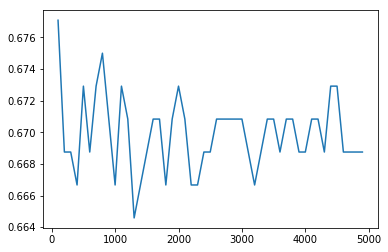

In [41]:
plt.plot(x, score)

----
Увеличение числа деревьев приводит к уменьшению точности, что говорит о переобучении.

----

### IV. Нейронные сети

*На обучение нейросетей может уйти больше часа, не откладывайте этот пункт на последний день*.

__9 (1 балл)__

В этом задании вам предстоит обучить нейронную сеть на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database) с помощью пакета [keras](https://keras.io).

In [42]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


Обучите нейронную сеть с двумя скрытыми слоями в каждой из которых поместите по 100 нейронов. Какого качества удается добиться на тесте?

In [43]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, MaxPooling1D, BatchNormalization


from keras import backend as K
from keras.utils import np_utils

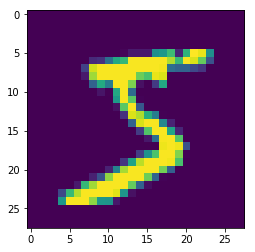

In [44]:
plt.imshow(x_train[0])

In [45]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [46]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [47]:
model = Sequential()

model = Sequential()
model.add(Dense(100, input_shape=(28**2,), activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [48]:
model.fit(x = x_train.reshape(x_train.shape[0],-1), 
          y = y_train, batch_size = 128, epochs = 6, verbose=1, 
          validation_data=(x_test.reshape(x_test.shape[0],-1), y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/6
60000/60000 [==============================] - 3s - loss: 1.3353 - acc: 0.6583 - val_loss: 0.6431 - val_acc: 0.8501
Epoch 2/6
60000/60000 [==============================] - 2s - loss: 0.5256 - acc: 0.8650 - val_loss: 0.4238 - val_acc: 0.8862
Epoch 3/6
60000/60000 [==============================] - 2s - loss: 0.4041 - acc: 0.8888 - val_loss: 0.3608 - val_acc: 0.8982
Epoch 4/6
60000/60000 [==============================] - 2s - loss: 0.3564 - acc: 0.8994 - val_loss: 0.3279 - val_acc: 0.9062
Epoch 5/6
60000/60000 [==============================] - 2s - loss: 0.3280 - acc: 0.9071 - val_loss: 0.3062 - val_acc: 0.9133
Epoch 6/6
60000/60000 [==============================] - 2s - loss: 0.3080 - acc: 0.9121 - val_loss: 0.2917 - val_acc: 0.9158


----
Добился точности 0.9158. Выглядит неплохо, но можно еще лучше :)

----

__10 (2 балл)__
Добавьте сверточные и pooling слои (вы можете также убрать Dense слои), добейтесь большего качества. Для успешного выполнения задания получите accuracy больше 0.99 на тестовой выборке. 

Рекомендации: после сверточных слоев наиболее эффективно добавлять MaxPooling слои, в конце перед последним слоем поставьте Dense слои с достаточно большим количеством нейронов. Подвигайте количество слоев, learning rate, функции активации.

подсмотрел здесь

https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/

In [49]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [50]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [51]:
model.fit(x = x_train, 
          y = y_train, batch_size = 32, epochs = 4, verbose=1, 
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 524s - loss: 0.1215 - acc: 0.9636 - val_loss: 0.0461 - val_acc: 0.9855
Epoch 2/4
60000/60000 [==============================] - 504s - loss: 0.0426 - acc: 0.9877 - val_loss: 0.0371 - val_acc: 0.9881
Epoch 3/4
60000/60000 [==============================] - 518s - loss: 0.0264 - acc: 0.9928 - val_loss: 0.0332 - val_acc: 0.9895
Epoch 4/4
60000/60000 [==============================] - 554s - loss: 0.0199 - acc: 0.9949 - val_loss: 0.0285 - val_acc: 0.9911


__11 (1 балл)__
Добавьте 1 или 2 dropout слоя внутрь сети предыдущего шага. Удается ли добиться большего качества? Что происходит с процессом обучения? 

In [55]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1), (60000, 10), (10000, 10))

In [52]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [53]:
model.fit(x = x_train, 
          y = y_train, batch_size = 32, epochs = 4, verbose=1, 
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 521s - loss: 0.3211 - acc: 0.8997 - val_loss: 0.0801 - val_acc: 0.9751
Epoch 2/4
60000/60000 [==============================] - 526s - loss: 0.1386 - acc: 0.9580 - val_loss: 0.0533 - val_acc: 0.9824
Epoch 3/4
60000/60000 [==============================] - 533s - loss: 0.1056 - acc: 0.9679 - val_loss: 0.0430 - val_acc: 0.9859
Epoch 4/4
60000/60000 [==============================] - 502s - loss: 0.0875 - acc: 0.9735 - val_loss: 0.0409 - val_acc: 0.9864


----
Точность примерно такая же, немного ниже, но очень высокая!

---